## 4.2 Tensor Flow Project (IMAGE): Deep Convolutional GAN - DCGAN

### 1. Batch Normalization  
### 2. DCGAN  

In [3]:
import tensorflow as tf
import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True, reshape=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### 1.1 Normal CNN

In [4]:
def fully_connected(prev_layer, num_units):
    """
    Create a fully connectd layer with the given layer as input and the given number of neurons.
    
    :param prev_layer: Tensor
        The Tensor that acts as input into this layer
    :param num_units: int
        The size of the layer. That is, the number of units, nodes, or neurons.
    :returns Tensor
        A new fully connected layer
    """
    layer = tf.layers.dense(prev_layer, num_units, activation=tf.nn.relu)
    return layer

def conv_layer(prev_layer, layer_depth):
    """
    Create a convolutional layer with the given layer as input.
    
    :param prev_layer: Tensor
        The Tensor that acts as input into this layer
    :param layer_depth: int
        We'll set the strides and number of feature maps based on the layer's depth in the network.
        This is *not* a good way to make a CNN, but it helps us create this example with very little code.
    :returns Tensor
        A new convolutional layer
    """
    strides = 2 if layer_depth % 3 == 0 else 1
    conv_layer = tf.layers.conv2d(prev_layer, layer_depth*4, 3, strides, 'same', activation=tf.nn.relu)
    return conv_layer

def train(num_batches, batch_size, learning_rate):
    # Build placeholders for the input samples and labels 
    inputs = tf.placeholder(tf.float32, [None, 28, 28, 1])
    labels = tf.placeholder(tf.float32, [None, 10])
    
    # Feed the inputs into a series of 20 convolutional layers 
    layer = inputs
    for layer_i in range(1, 20):
        layer = conv_layer(layer, layer_i)

    # Flatten the output from the convolutional layers 
    orig_shape = layer.get_shape().as_list()
    layer = tf.reshape(layer, shape=[-1, orig_shape[1] * orig_shape[2] * orig_shape[3]])

    # Add one fully connected layer
    layer = fully_connected(layer, 100)

    # Create the output layer with 1 node for each 
    logits = tf.layers.dense(layer, 10)
    
    # Define loss and training operations
    model_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
    train_opt = tf.train.AdamOptimizer(learning_rate).minimize(model_loss)
    
    # Create operations to test accuracy
    correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(labels,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # Train and test the network
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for batch_i in range(num_batches):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # train this batch
            sess.run(train_opt, {inputs: batch_xs, labels: batch_ys})
            
            # Periodically check the validation or training loss and accuracy
            if batch_i % 100 == 0:
                loss, acc = sess.run([model_loss, accuracy], {inputs: mnist.validation.images,
                                                              labels: mnist.validation.labels})
                print('Batch: {:>2}: Validation loss: {:>3.5f}, Validation accuracy: {:>3.5f}'.format(batch_i, loss, acc))
            elif batch_i % 25 == 0:
                loss, acc = sess.run([model_loss, accuracy], {inputs: batch_xs, labels: batch_ys})
                print('Batch: {:>2}: Training loss: {:>3.5f}, Training accuracy: {:>3.5f}'.format(batch_i, loss, acc))

        # At the end, score the final accuracy for both the validation and test sets
        acc = sess.run(accuracy, {inputs: mnist.validation.images,
                                  labels: mnist.validation.labels})
        print('Final validation accuracy: {:>3.5f}'.format(acc))
        acc = sess.run(accuracy, {inputs: mnist.test.images,
                                  labels: mnist.test.labels})
        print('Final test accuracy: {:>3.5f}'.format(acc))
        
        # Score the first 100 test images individually. This won't work if batch normalization isn't implemented correctly.
        correct = 0
        for i in range(100):
            correct += sess.run(accuracy,feed_dict={inputs: [mnist.test.images[i]],
                                                    labels: [mnist.test.labels[i]]})

        print("Accuracy on 100 samples:", correct/100)


num_batches = 800
batch_size = 64
learning_rate = 0.002

tf.reset_default_graph()
with tf.Graph().as_default():
    train(num_batches, batch_size, learning_rate)

Batch:  0: Validation loss: 0.69109, Validation accuracy: 0.09900
Batch: 25: Training loss: 0.39532, Training accuracy: 0.12500
Batch: 50: Training loss: 0.33017, Training accuracy: 0.06250
Batch: 75: Training loss: 0.32361, Training accuracy: 0.20312
Batch: 100: Validation loss: 0.32556, Validation accuracy: 0.11260
Batch: 125: Training loss: 0.32438, Training accuracy: 0.06250
Batch: 150: Training loss: 0.32572, Training accuracy: 0.06250
Batch: 175: Training loss: 0.32612, Training accuracy: 0.06250
Batch: 200: Validation loss: 0.32560, Validation accuracy: 0.09860
Batch: 225: Training loss: 0.33030, Training accuracy: 0.04688
Batch: 250: Training loss: 0.32497, Training accuracy: 0.10938
Batch: 275: Training loss: 0.32598, Training accuracy: 0.03125
Batch: 300: Validation loss: 0.32625, Validation accuracy: 0.09580
Batch: 325: Training loss: 0.32607, Training accuracy: 0.07812
Batch: 350: Training loss: 0.32670, Training accuracy: 0.09375
Batch: 375: Training loss: 0.32726, Trainin

### 1.2 Implement with tf.layers.batch_normalization

In [5]:
def fully_connected(prev_layer, num_units, is_training):
    layer = tf.layers.dense(prev_layer, num_units, use_bias=False, activation=None)
    layer = tf.layers.batch_normalization(layer, training=is_training)
    layer = tf.nn.relu(layer)
    return layer

def conv_layer(prev_layer, layer_depth, is_training):
    strides = 2 if layer_depth % 3 == 0 else 1
    conv_layer = tf.layers.conv2d(prev_layer, layer_depth*4, 3, strides, 'same', use_bias=False, activation=None)
    conv_layer = tf.layers.batch_normalization(conv_layer, training=is_training)
    conv_layer = tf.nn.relu(conv_layer)
    return conv_layer

def train(num_batches, batch_size, learning_rate):
 
    inputs = tf.placeholder(tf.float32, [None, 28, 28, 1])
    labels = tf.placeholder(tf.float32, [None, 10])
    
    
    is_training = tf.placeholder(tf.bool)
    
    layer = inputs
    for layer_i in range(1, 20):
        layer = conv_layer(layer, layer_i, is_training)

    orig_shape = layer.get_shape().as_list()
    layer = tf.reshape(layer, shape=[-1, orig_shape[1] * orig_shape[2] * orig_shape[3]])

    layer = fully_connected(layer, 100, is_training)

    logits = tf.layers.dense(layer, 10)
    
    model_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        train_opt = tf.train.AdamOptimizer(learning_rate).minimize(model_loss)
    
    correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(labels,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # Train and test the network
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for batch_i in range(num_batches):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # train this batch
            sess.run(train_opt, {inputs: batch_xs, labels: batch_ys, is_training: True})
            
            # Periodically check the validation or training loss and accuracy
            if batch_i % 100 == 0:
                loss, acc = sess.run([model_loss, accuracy], {inputs: mnist.validation.images,
                                                              labels: mnist.validation.labels,
                                                              is_training: False})
                print('Batch: {:>2}: Validation loss: {:>3.5f}, Validation accuracy: {:>3.5f}'.format(batch_i, loss, acc))
            elif batch_i % 25 == 0:
                loss, acc = sess.run([model_loss, accuracy], {inputs: batch_xs, labels: batch_ys, is_training: False})
                print('Batch: {:>2}: Training loss: {:>3.5f}, Training accuracy: {:>3.5f}'.format(batch_i, loss, acc))

        # At the end, score the final accuracy for both the validation and test sets
        acc = sess.run(accuracy, {inputs: mnist.validation.images,
                                  labels: mnist.validation.labels,
                                  is_training: False})
        print('Final validation accuracy: {:>3.5f}'.format(acc))
        acc = sess.run(accuracy, {inputs: mnist.test.images,
                                  labels: mnist.test.labels,
                                  is_training: False})
        print('Final test accuracy: {:>3.5f}'.format(acc))
        
        # Score the first 100 test images individually. This won't work if batch normalization isn't implemented correctly.
        correct = 0
        for i in range(100):
            correct += sess.run(accuracy,feed_dict={inputs: [mnist.test.images[i]],
                                                    labels: [mnist.test.labels[i]],
                                                    is_training: False})

        print("Accuracy on 100 samples:", correct/100)


num_batches = 800
batch_size = 64
learning_rate = 0.002

tf.reset_default_graph()
with tf.Graph().as_default():
    train(num_batches, batch_size, learning_rate)

Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use tf.cast instead.
Batch:  0: Validation loss: 0.69122, Validation accuracy: 0.11000
Batch: 25: Training loss: 0.58460, Training accuracy: 0.12500
Batch: 50: Training loss: 0.48328, Training accuracy: 0.15625
Batch: 75: Training loss: 0.41478, Training accuracy: 0.14062
Batch: 100: Validation loss: 0.37273, Validation accuracy: 0.09900
Batch: 125: Training loss: 0.34410, Training accuracy: 0.15625
Batch: 150: Training loss: 0.33150, Training accuracy: 0.17188
Batch: 175: Training loss: 0.31906, Training accuracy: 0.18750
Batch: 200: Validation loss: 0.23938, Validation accuracy: 0.51560
Batch: 225: Training loss: 0.21151, Training accuracy: 0.60938
Batch: 250: Training loss: 0.12145, Training accuracy: 0.87500
Batch: 275: Training loss: 0.04799, Training accuracy: 0.93750
Batch: 300: Validation loss: 0.10232, Validation accuracy: 0.85200
Batch: 325: Training loss: 0.01307, Training acc

### 1.3 Implement with tf.nn.batch_normalization - lower level to implement new features, such as in LSTM

In [8]:
def fully_connected(prev_layer, num_units, is_training):

    layer = tf.layers.dense(prev_layer, num_units, use_bias=False, activation=None)
    
    gamma = tf.Variable(tf.ones([num_units]))
    beta = tf.Variable(tf.zeros([num_units]))
    
    pop_mean = tf.Variable(tf.zeros(num_units), trainable=False)
    pop_var = tf.Variable(tf.ones(num_units), trainable=False)
    
    epsilon = 1e-3
    
    def batch_norm_training():
        batch_mean, batch_var = tf.nn.moments(layer, [0])
        decay = 0.99
        train_mean = tf.assign(pop_mean, pop_mean*decay + batch_mean *(1-decay))
        train_var = tf.assign(pop_var, pop_var * decay + batch_var * (1-decay))
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(layer, batch_mean, batch_var, beta, gamma, epsilon)
    
    def batch_norm_inference():
        return tf.nn.batch_normalization(layer, pop_mean, pop_var, beta, gamma, epsilon)
    
    batch_normalized_out = tf.cond(is_training, batch_norm_training, batch_norm_inference)
  
    return tf.nn.relu(batch_normalized_out)

def conv_layer(prev_layer, layer_depth, is_training):
    strides = 2 if layer_depth % 3 == 0 else 1

    in_channels = prev_layer.get_shape().as_list()[3]
    out_channels = layer_depth*4
    
    weights = tf.Variable(
        tf.truncated_normal([3, 3, in_channels, out_channels], stddev=0.05))
    
    layer = tf.nn.conv2d(prev_layer, weights, strides=[1,strides, strides, 1], padding='SAME')
    
    gamma = tf.Variable(tf.ones([out_channels]))
    beta = tf.Variable(tf.zeros([out_channels]))
    
    pop_mean = tf.Variable(tf.zeros(out_channels), trainable=False)
    pop_var = tf.Variable(tf.ones(out_channels), trainable=False)
    
    epsilon = 1e-3
    
    def batch_norm_training():
        batch_mean, batch_var = tf.nn.moments(layer, [0, 1, 2], keep_dims=False)
        decay = 0.99
        train_mean = tf.assign(pop_mean, pop_mean*decay + batch_mean *(1-decay))
        train_var = tf.assign(pop_var, pop_var * decay + batch_var * (1-decay))
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(layer, batch_mean, batch_var, beta, gamma, epsilon)
    
    def batch_norm_inference():
        return tf.nn.batch_normalization(layer, pop_mean, pop_var, beta, gamma, epsilon)
    
    batch_normalized_out = tf.cond(is_training, batch_norm_training, batch_norm_inference)
    
 
    return tf.nn.relu(batch_normalized_out)

def train(num_batches, batch_size, learning_rate):
    # Build placeholders for the input samples and labels 
    inputs = tf.placeholder(tf.float32, [None, 28, 28, 1])
    labels = tf.placeholder(tf.float32, [None, 10])

    # Add placeholder to indicate whether or not we're training the model
    is_training = tf.placeholder(tf.bool)

    # Feed the inputs into a series of 20 convolutional layers 
    layer = inputs
    for layer_i in range(1, 20):
        layer = conv_layer(layer, layer_i, is_training)

    # Flatten the output from the convolutional layers 
    orig_shape = layer.get_shape().as_list()
    layer = tf.reshape(layer, shape=[-1, orig_shape[1] * orig_shape[2] * orig_shape[3]])

    # Add one fully connected layer
    layer = fully_connected(layer, 100, is_training)

    # Create the output layer with 1 node for each 
    logits = tf.layers.dense(layer, 10)
    
    # Define loss and training operations
    model_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
    train_opt = tf.train.AdamOptimizer(learning_rate).minimize(model_loss)
    
    # Create operations to test accuracy
    correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(labels,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # Train and test the network
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for batch_i in range(num_batches):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # train this batch
            sess.run(train_opt, {inputs: batch_xs, labels: batch_ys, is_training: True})
            
            # Periodically check the validation or training loss and accuracy
            if batch_i % 100 == 0:
                loss, acc = sess.run([model_loss, accuracy], {inputs: mnist.validation.images,
                                                              labels: mnist.validation.labels,
                                                              is_training: False})
                print('Batch: {:>2}: Validation loss: {:>3.5f}, Validation accuracy: {:>3.5f}'.format(batch_i, loss, acc))
            elif batch_i % 25 == 0:
                loss, acc = sess.run([model_loss, accuracy], {inputs: batch_xs, labels: batch_ys, is_training: False})
                print('Batch: {:>2}: Training loss: {:>3.5f}, Training accuracy: {:>3.5f}'.format(batch_i, loss, acc))

        # At the end, score the final accuracy for both the validation and test sets
        acc = sess.run(accuracy, {inputs: mnist.validation.images,
                                  labels: mnist.validation.labels, 
                                  is_training: False})
        print('Final validation accuracy: {:>3.5f}'.format(acc))
        acc = sess.run(accuracy, {inputs: mnist.test.images,
                                  labels: mnist.test.labels,
                                  is_training: False})
        print('Final test accuracy: {:>3.5f}'.format(acc))
        
        # Score the first 100 test images individually, just to make sure batch normalization really worked
        correct = 0
        for i in range(100):
            correct += sess.run(accuracy,feed_dict={inputs: [mnist.test.images[i]],
                                                    labels: [mnist.test.labels[i]],
                                                    is_training: False})

        print("Accuracy on 100 samples:", correct/100)


num_batches = 800
batch_size = 64
learning_rate = 0.002

tf.reset_default_graph()
with tf.Graph().as_default():
    train(num_batches, batch_size, learning_rate)

Batch:  0: Validation loss: 0.69035, Validation accuracy: 0.09240
Batch: 25: Training loss: 0.57337, Training accuracy: 0.09375
Batch: 50: Training loss: 0.46303, Training accuracy: 0.04688
Batch: 75: Training loss: 0.39606, Training accuracy: 0.06250
Batch: 100: Validation loss: 0.35822, Validation accuracy: 0.09240
Batch: 125: Training loss: 0.35436, Training accuracy: 0.07812
Batch: 150: Training loss: 0.35139, Training accuracy: 0.14062
Batch: 175: Training loss: 0.40521, Training accuracy: 0.06250
Batch: 200: Validation loss: 0.38157, Validation accuracy: 0.09860
Batch: 225: Training loss: 0.49637, Training accuracy: 0.06250
Batch: 250: Training loss: 0.47377, Training accuracy: 0.15625
Batch: 275: Training loss: 0.73426, Training accuracy: 0.12500
Batch: 300: Validation loss: 0.75913, Validation accuracy: 0.09860
Batch: 325: Training loss: 0.68728, Training accuracy: 0.14062
Batch: 350: Training loss: 0.68387, Training accuracy: 0.10938
Batch: 375: Training loss: 0.83173, Trainin

### 2. DCGAN with SVHN (Street View House Numbers)

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = '../ClassSampleData/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

In [2]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(self.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

In [3]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
        return out

def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

In [4]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

In [9]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 25
alpha = 0.2
beta1 = 0.5

# Create the network
# Comment out following codes to remove output (too big to upload)
# net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)
# dataset = Dataset(trainset, testset)

# losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

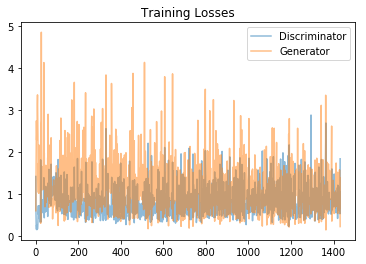

In [6]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

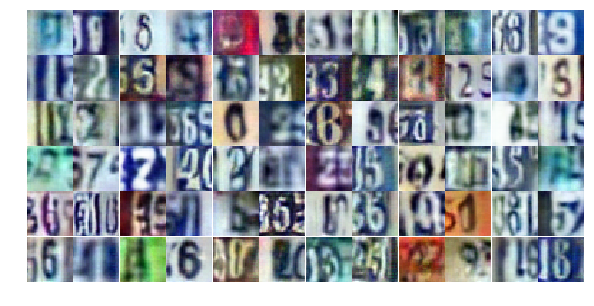

In [7]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))